## Hummingbird dataset from Google Images - using Resnet50
*by Nissan Dookeran*

*based on original lesson 2 by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this notebook I use a created image dataset from Google Images using the technique described in the Downloads notebook that consisted of species of hummingbirds commonly found in Trinidad and Tobago. The initial run was as good as the [test done previously](https://gist.github.com/nissan/a225e6cf1a87ecde69f7eb78e30de163) on [Bird Species](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset at around 25% error rate when I had only 3 species categorised but resulted in very poor performance (around 50% error rate) when more species were added. 

Analysis of the data indicated that while most of the images retrieved were always hummingbirds, the species of images wwas sometimes incorrect so there was a mismatch between the keyword search and the image dataset retrieved thru Google Images. The first step was for the wrongly matched species of hummingbird to be deleted from these folders.

Additionally, for some species, physical traits of male and females of each species were varied, and this too I make a guess that this may be the source of the issue with the classifier's misclassifications, so at the very least, separating by gender could indicate if mismatches were because of confusion between specific genders of specific species and not the two species in general. 

So images for species were manually divided into male and female images and placed in separate category folders based on a little research done into what the traits were that distinguished the male and female of a species of hummingbird. Sometimes these traits were very small or not distinguishable, so for these species no segmentation by gender was done. This notebook runs with this data cleanup and new separations to evaluate if performance improved with this.

## Setup datasets

### Initialization of data, cleanup any bad images still around

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
bs = 32
size=299
path = Path('data/h3')

Good! Let's take a look at some of our pictures then.

In [4]:
classes = ['ruby_topaz_female',
           'ruby_topaz_male',
           'black_throated_mango_female',
           'black_throated_mango_male',
           'blue_chinned_sapphire_female',
           'blue_chinned_sapphire_male',
           'blue_tailed_emerald_female',
           'blue_tailed_emerald_male',
           'brown_violetear',
           'copper_rumped',
           'green_throated_mango',
           'long_billed_starthroat',
           'tufted_coquette_female',
           'tufted_coquette_male'
          ]

In [5]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

ruby_topaz_female


ruby_topaz_male


black_throated_mango_female


black_throated_mango_male


blue_chinned_sapphire_female


blue_chinned_sapphire_male


blue_tailed_emerald_female


blue_tailed_emerald_male


brown_violetear


copper_rumped


green_throated_mango


long_billed_starthroat


tufted_coquette_female


tufted_coquette_male


## View data

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,bs=bs, size=size,
        ds_tfms=get_transforms(), num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['black_throated_mango_female',
 'black_throated_mango_male',
 'blue_chinned_sapphire_female',
 'blue_chinned_sapphire_male',
 'blue_tailed_emerald_female',
 'blue_tailed_emerald_male',
 'brown_violetear',
 'copper_rumped',
 'green_throated_mango',
 'long_billed_starthroat',
 'ruby_topaz_female',
 'ruby_topaz_male',
 'tufted_coquette_female',
 'tufted_coquette_male']

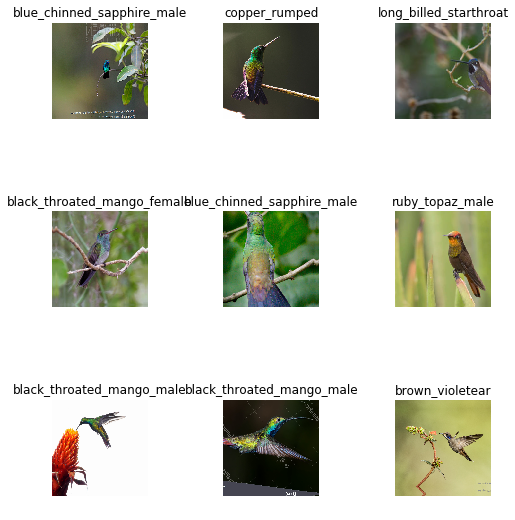

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black_throated_mango_female',
  'black_throated_mango_male',
  'blue_chinned_sapphire_female',
  'blue_chinned_sapphire_male',
  'blue_tailed_emerald_female',
  'blue_tailed_emerald_male',
  'brown_violetear',
  'copper_rumped',
  'green_throated_mango',
  'long_billed_starthroat',
  'ruby_topaz_female',
  'ruby_topaz_male',
  'tufted_coquette_female',
  'tufted_coquette_male'],
 14,
 1044,
 292)

## Train model

In [19]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [20]:
learn.fit_one_cycle(4)

Total time: 02:34
epoch  train_loss  valid_loss  error_rate
1      1.991551    1.040884    0.359589    (00:38)
2      1.309933    0.824304    0.287671    (00:38)
3      0.895824    0.777432    0.263699    (00:38)
4      0.659662    0.801769    0.270548    (00:38)



In [21]:
learn.save('stage-1-50')

In [35]:
learn.load('stage-1-50')

In [36]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


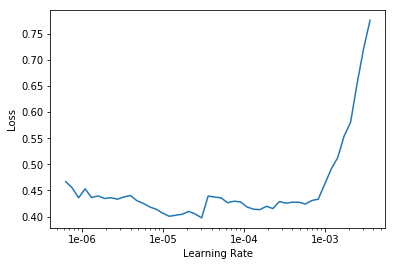

In [25]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

Total time: 01:40
epoch  train_loss  valid_loss  error_rate
1      0.466237    0.760793    0.250000    (00:49)
2      0.369824    0.717443    0.239726    (00:50)



In [38]:
learn.save('stage-2-50')

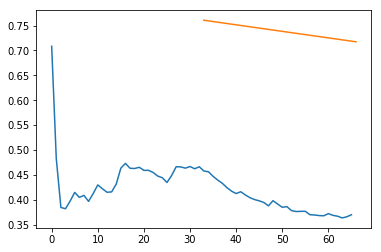

In [39]:
learn.recorder.plot_losses()

## Interpretation

In [40]:
interp = ClassificationInterpretation.from_learner(learn)

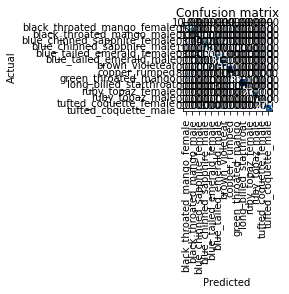

In [41]:
interp.plot_confusion_matrix()

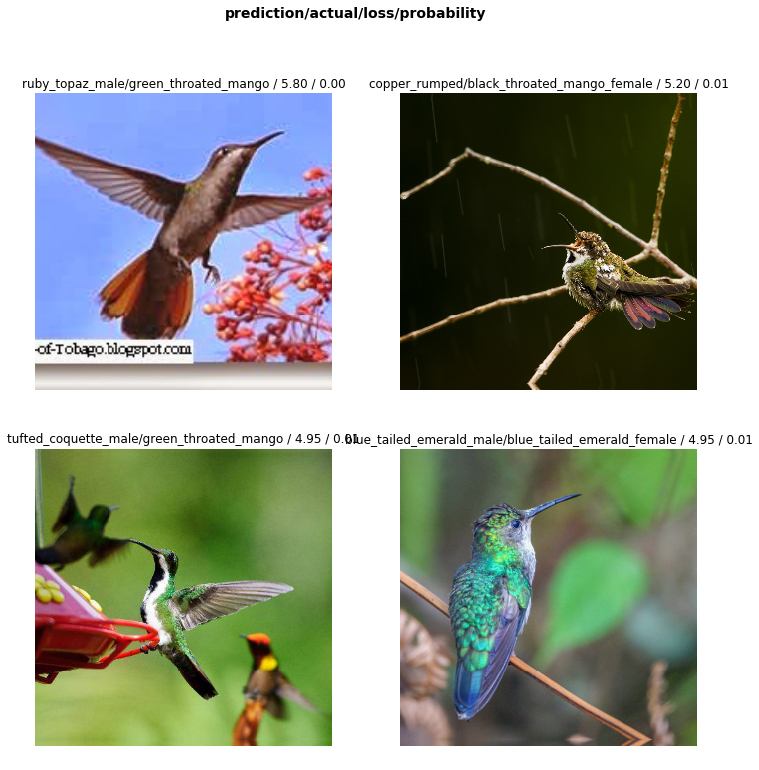

In [42]:
interp.plot_top_losses(4)

In [43]:
interp.most_confused(min_val=2)

[('black_throated_mango_female', 'green_throated_mango', 10),
 ('green_throated_mango', 'black_throated_mango_female', 8),
 ('blue_chinned_sapphire_female', 'blue_chinned_sapphire_male', 4),
 ('blue_tailed_emerald_male', 'blue_chinned_sapphire_male', 4),
 ('blue_chinned_sapphire_male', 'black_throated_mango_male', 3),
 ('blue_tailed_emerald_female', 'blue_tailed_emerald_male', 3),
 ('blue_tailed_emerald_male', 'black_throated_mango_male', 3),
 ('ruby_topaz_female', 'brown_violetear', 3)]

#### Performance is about the same as with ResNet34, as error rate is still about 24% comparible to training on the bird species dataset.

Notes: In researching literature on Hummingbird species, it was noted that green throated mangos and black throated mangos are often confused by humans as well in real world nature observations. Additionally male and female confusions are common for some species are also common with human observers. So on anacdotal evidence only the model can be said to not be doing too badly when compared to human recognition.